In [1]:
import warnings
import awkward as ak
import hist as hs
from hist.intervals import ratio_uncertainty
import numpy as np

import mplhep as hep
import matplotlib.pyplot as plt

import pickle

plt.style.use(hep.style.CMS)
#plt.style.use('dark_background')

In [2]:
infile = open("csc_bkg_sig.pickle",'rb')
out = pickle.load(infile)
infile.close()

In [6]:
datasets = [key for key in out.keys() if 'cuts' not in key and 'vars' not in key]

sigcuts = [key for key in out.keys() if 'cuts' in key and 'Phi' in key]
bkguts = [key for key in out.keys() if 'cuts' in key and 'Background' in key]

sigvars = [key for key in out.keys() if 'vars' in key and 'Phi' in key]
bkgvars = [key for key in out.keys() if 'vars' in key and 'Background' in key]

In [7]:
print(datasets)
print(sigcuts)
print(sigvars)

['backgroundNew', 'PhiToPiPlusPiMinus_mPhi0p3_ctau300', 'PhiToPi0Pi0_mPhi1p0_ctau300']
['PhiToPiPlusPiMinus_mPhi0p3_ctau300_cuts', 'PhiToPi0Pi0_mPhi1p0_ctau300_cuts']
['PhiToPiPlusPiMinus_mPhi0p3_ctau300_vars', 'PhiToPi0Pi0_mPhi1p0_ctau300_vars']


In [22]:
signame = "Phi"
reg = 'csc'
for dataset in datasets:
    print(dataset)
    if signame in dataset:
        if 'ctau1000' in dataset:
            oldctau = 100
        if 'ctau300' in dataset:
            oldctau = 30

        N_events_acceptance = out[dataset]["numEvents_llp_acc"]
        N_events_no_cut = out[dataset]["numEvents_posttrigger"]

        # _________________ Efficiency calculation _________________
        eff_sig_old = N_events_acceptance / N_events_no_cut

        def weight_calc(llp_ct, new_ctau, old_ctau):
            return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))

        ctau_list = np.logspace(-.3, 4, 50)
        eff = np.zeros_like(ctau_list)
        gLLP_ctau = np.array(out[f"{dataset}_vars"]["gLLP_ctau with llp_acc"]) #cuts gLLP_ctau

        for i, ct in enumerate(ctau_list):
            weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
            eff_sig_new = np.sum(weight_ctau)/out[dataset]["numEvents_posttrigger"]
            eff[i] = eff_sig_new

        out[dataset]['ctau_list'] = ctau_list
        out[dataset]['eff'] = eff

        # _________________ Branching ratio estimation _________________
        cutevents = out[dataset]["numEvents_posttrigger"]
        n_events_inverse = 1/cutevents
        print(N_events_acceptance*n_events_inverse)

        def weight_calc(llp_ct, new_ctau, old_ctau):
            return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))

        br = np.zeros_like(ctau_list)

        gLLP_ctau = np.array(out[f"{dataset}_vars"]["gLLP_ctau with cls_size > 130"]) #cuts gLLP_ctau

        nb = 55
        frac_of_B = .02
        BR_old = 2*np.sqrt(nb/frac_of_B)/(5e9*N_events_acceptance*n_events_inverse)

        for i, ct in enumerate(ctau_list):
            weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
            BR_new = 2*np.sqrt(nb/frac_of_B)/(5e9*sum(weight_ctau)*n_events_inverse)
            br[i] = BR_new

        out[dataset]['br'] = br
        # <<< eff and br calculation <<<

backgroundNew
PhiToPiPlusPiMinus_mPhi0p3_ctau300
0.38816927173897514
PhiToPi0Pi0_mPhi1p0_ctau300
0.3583942612774176


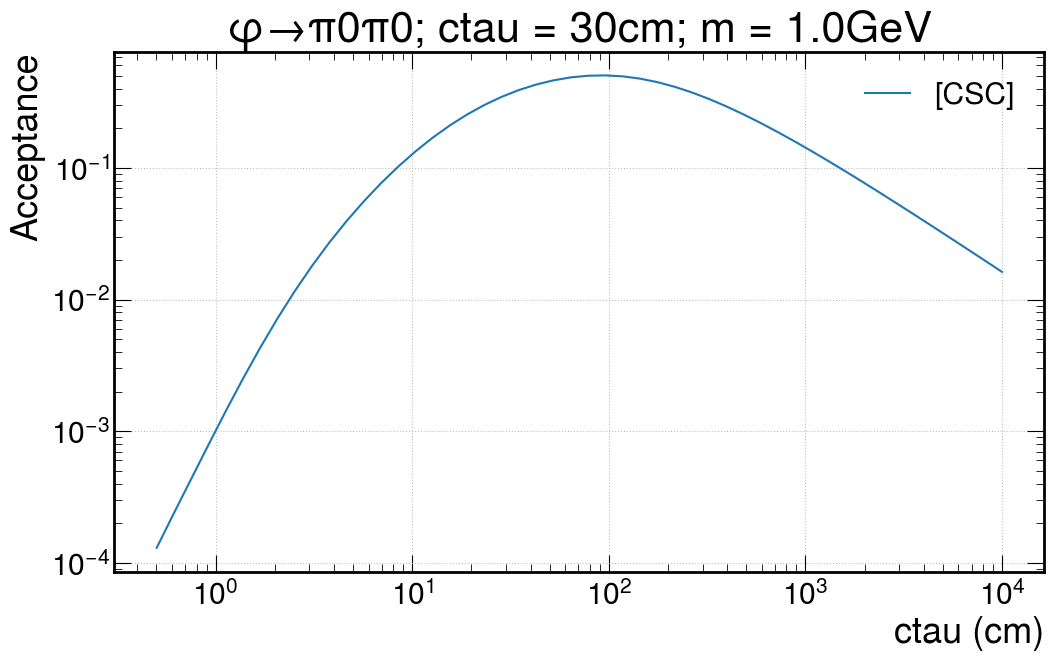

In [31]:
a = .75
fig, ax = plt.subplots(1,1, figsize = (a*16,a*9))
key = 'PhiToPi0Pi0_mPhi1p0_ctau300'

s = ''
if 'PiPlusPiMinus' in key:
    s+='φ→π+π-; '
if 'Pi0Pi0' in key:
    s+='φ→π0π0; '

if 'ctau1000' in key:
    s+='ctau = 100cm; '
if 'ctau300' in key:
    s+='ctau = 30cm; '

if '0p3' in key:
    s+='m = 0.3GeV'
if '1p0' in key:
    s+='m = 1.0GeV'

ax.plot(out[key]['ctau_list'], out[key]['eff'], label = '[CSC]')

plt.title(s)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ctau (cm)")
plt.ylabel("Acceptance")
plt.legend()
plt.grid()
plt.show()

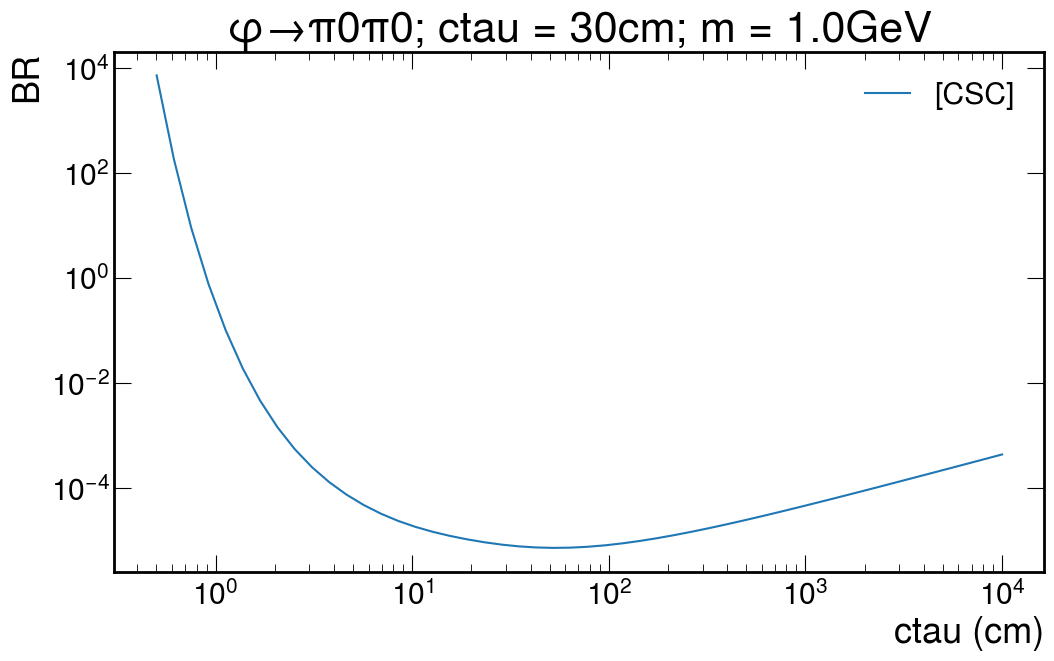

In [32]:
key = 'PhiToPi0Pi0_mPhi1p0_ctau300'

fig, ax = plt.subplots(1,1, figsize = (a*16,a*9))

s = ''
if 'PiPlusPiMinus' in key:
    s+='φ→π+π-; '
if 'Pi0Pi0' in key:
    s+='φ→π0π0; '

if 'ctau1000' in key:
    s+='ctau = 100cm; '
if 'ctau300' in key:
    s+='ctau = 30cm; '

if '0p3' in key:
    s+='m = 0.3GeV'
if '1p0' in key:
    s+='m = 1.0GeV'

ax.plot(out[key]['ctau_list'], out[key]['br'], label = '[CSC]')

plt.title(s)  
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ctau (cm)")
plt.ylabel("BR")
plt.legend()
plt.show()

In [34]:
#datasets = list(fileset.keys())

for dataset in datasets:
    print(dataset)
    i = 1
    for key in out[dataset]:
        if key.startswith('numEvents_'):# and ('NStation10' not in key):
            print(f"{key[10:]}, {out[dataset][key]}")
            i+=1
            #print(f"{out[dataset][key]}")
    print()

backgroundNew
pretrigger, 25667521
|muonId| == 13, 25667155
muonHLTReq, 24764401
|muonEta| < 1.5, 22954060
muonPt > 7, 22896397
soft_muon_ID, 22039911
leadMuon_cut, 22039911
posttrigger, 22039911
llp_acc, 22039911
num Cluster > 0, 5032009
dR_gllp_cls < .4, 5032009
dR_lmuon_cls > .8, 3638409
ME1112_veto, 225311
re12_veto, 223242
mb1_veto, 221292
rb1_veto, 220292
muon_veto_pt < 20, 219480
-5 < cls_time < 12.5, 37360
|cls_timeSpread| < 20, 25562
|cls_eta| < 1.9, 4713
cut_based_ID, 2504
cls_size > 130, 94

PhiToPiPlusPiMinus_mPhi0p3_ctau300
pretrigger, 1551411
|muonId| == 13, 1551319
muonHLTReq, 219683
|muonEta| < 1.5, 214992
muonPt > 7, 213451
soft_muon_ID, 209911
leadMuon_cut, 209911
posttrigger, 209911
llp_acc, 81481
num Cluster > 0, 12753
dR_gllp_cls < .4, 10210
dR_lmuon_cls > .8, 9735
ME1112_veto, 5919
re12_veto, 5850
mb1_veto, 5740
rb1_veto, 5693
muon_veto_pt < 20, 5518
-5 < cls_time < 12.5, 5500
|cls_timeSpread| < 20, 5283
|cls_eta| < 1.9, 3106
cut_based_ID, 2564
cls_size > 130, 676

In [50]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(num, den, rax):

    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "efficiency"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(400,1075)
    (xmin,xmax) = ax.get_xlim()
    f = 16
    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=f)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=f)
    ax.text(800, y_max*1.02, 'ME2', fontsize=f)
    ax.text(920, y_max*1.02, 'ME3', fontsize=f)
    ax.text(1015, y_max*1.02,'ME4', fontsize=f)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax


In [13]:
out[key]['gLLP_decay_vertex_z_matched with no_cut'].sum()/out[key]['gLLP_decay_vertex_z with no_cut'].sum()

0.08146477378267215

φ→π+π-; ctau = 1000mm; m = 0.3GeV; 
 0.015177910889435124
φ→π+π-; ctau = 300mm; m = 0.3GeV; 
 0.022362261433201296
φ→π0π0; ctau = 300mm; m = 0.3GeV; 
 0.015510509707439696
φ→π0π0; ctau = 1000mm; m = 0.3GeV; 
 0.013081435377709234


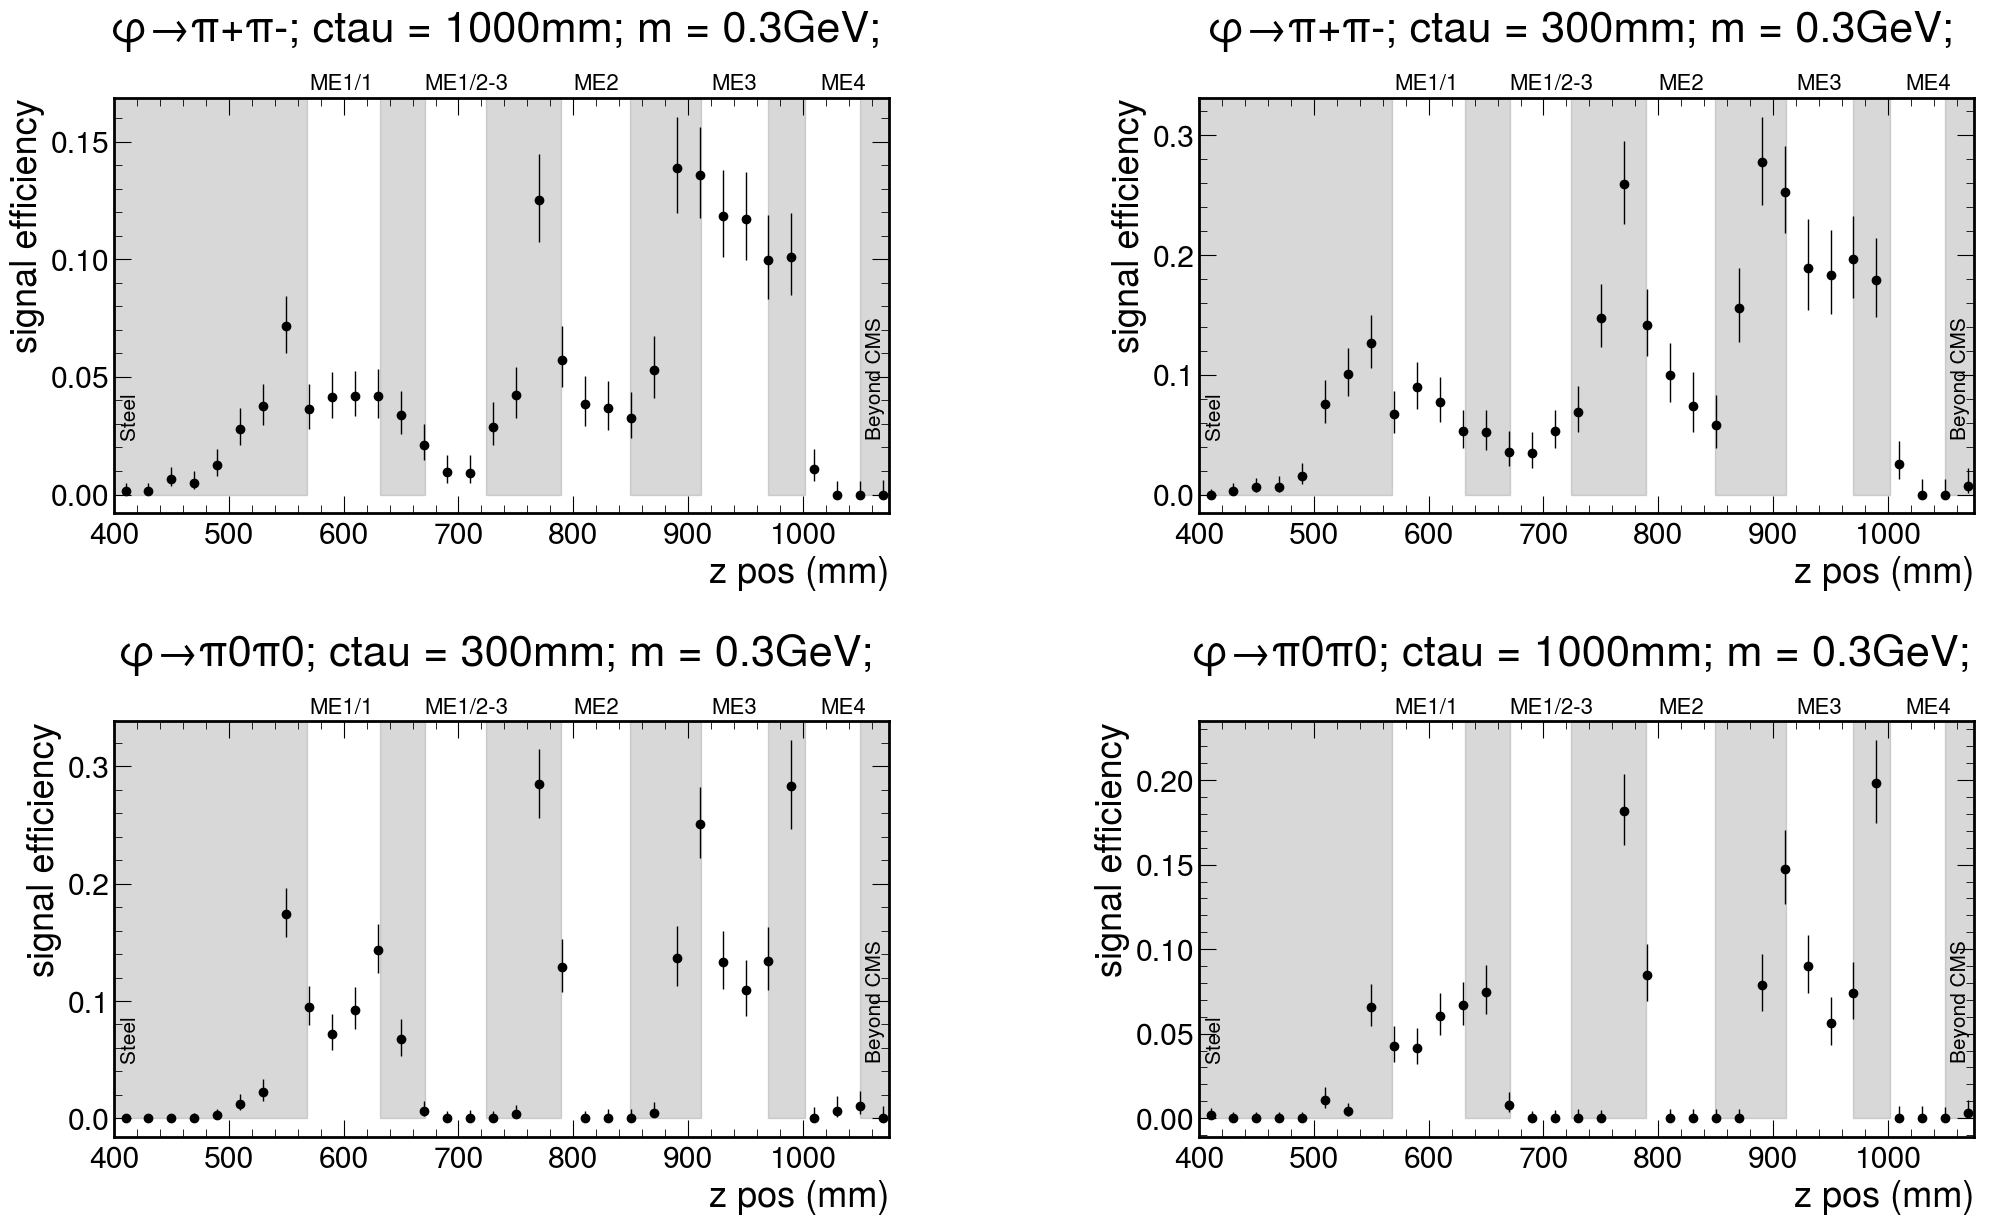

In [54]:
a = 1.5
fig, axes = plt.subplots(2,2, figsize = (a*16,a*9))
reg = 'csc'
for ax, key in zip(axes.flatten(), ['PhiToPiPlusPiMinus_mPhi0p3_ctau1000','PhiToPiPlusPiMinus_mPhi0p3_ctau300','PhiToPi0Pi0_mPhi0p3_ctau300','PhiToPi0Pi0_mPhi0p3_ctau1000',]):
    ratio(out[key]['gLLP_decay_vertex_z_matched with posttrigger'], out[key]['gLLP_decay_vertex_z with posttrigger'], ax)
    drawCSCz(ax)
    ax.set_xlabel("z pos (mm)")
    ax.set_ylabel("signal efficiency")
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '
        
    if '0p3' in key:
        s+='m = 0.3GeV; \n'
    if '1p0' in key:
        s+='m = 1.0GeV; \n'
        
    ax.set_title(s)
    
    print(s, out[key]['gLLP_decay_vertex_z_matched with posttrigger'].sum()/out[key]['gLLP_decay_vertex_z with posttrigger'].sum())
        
fig.subplots_adjust(hspace=.5, wspace=.4)
        
plt.show()

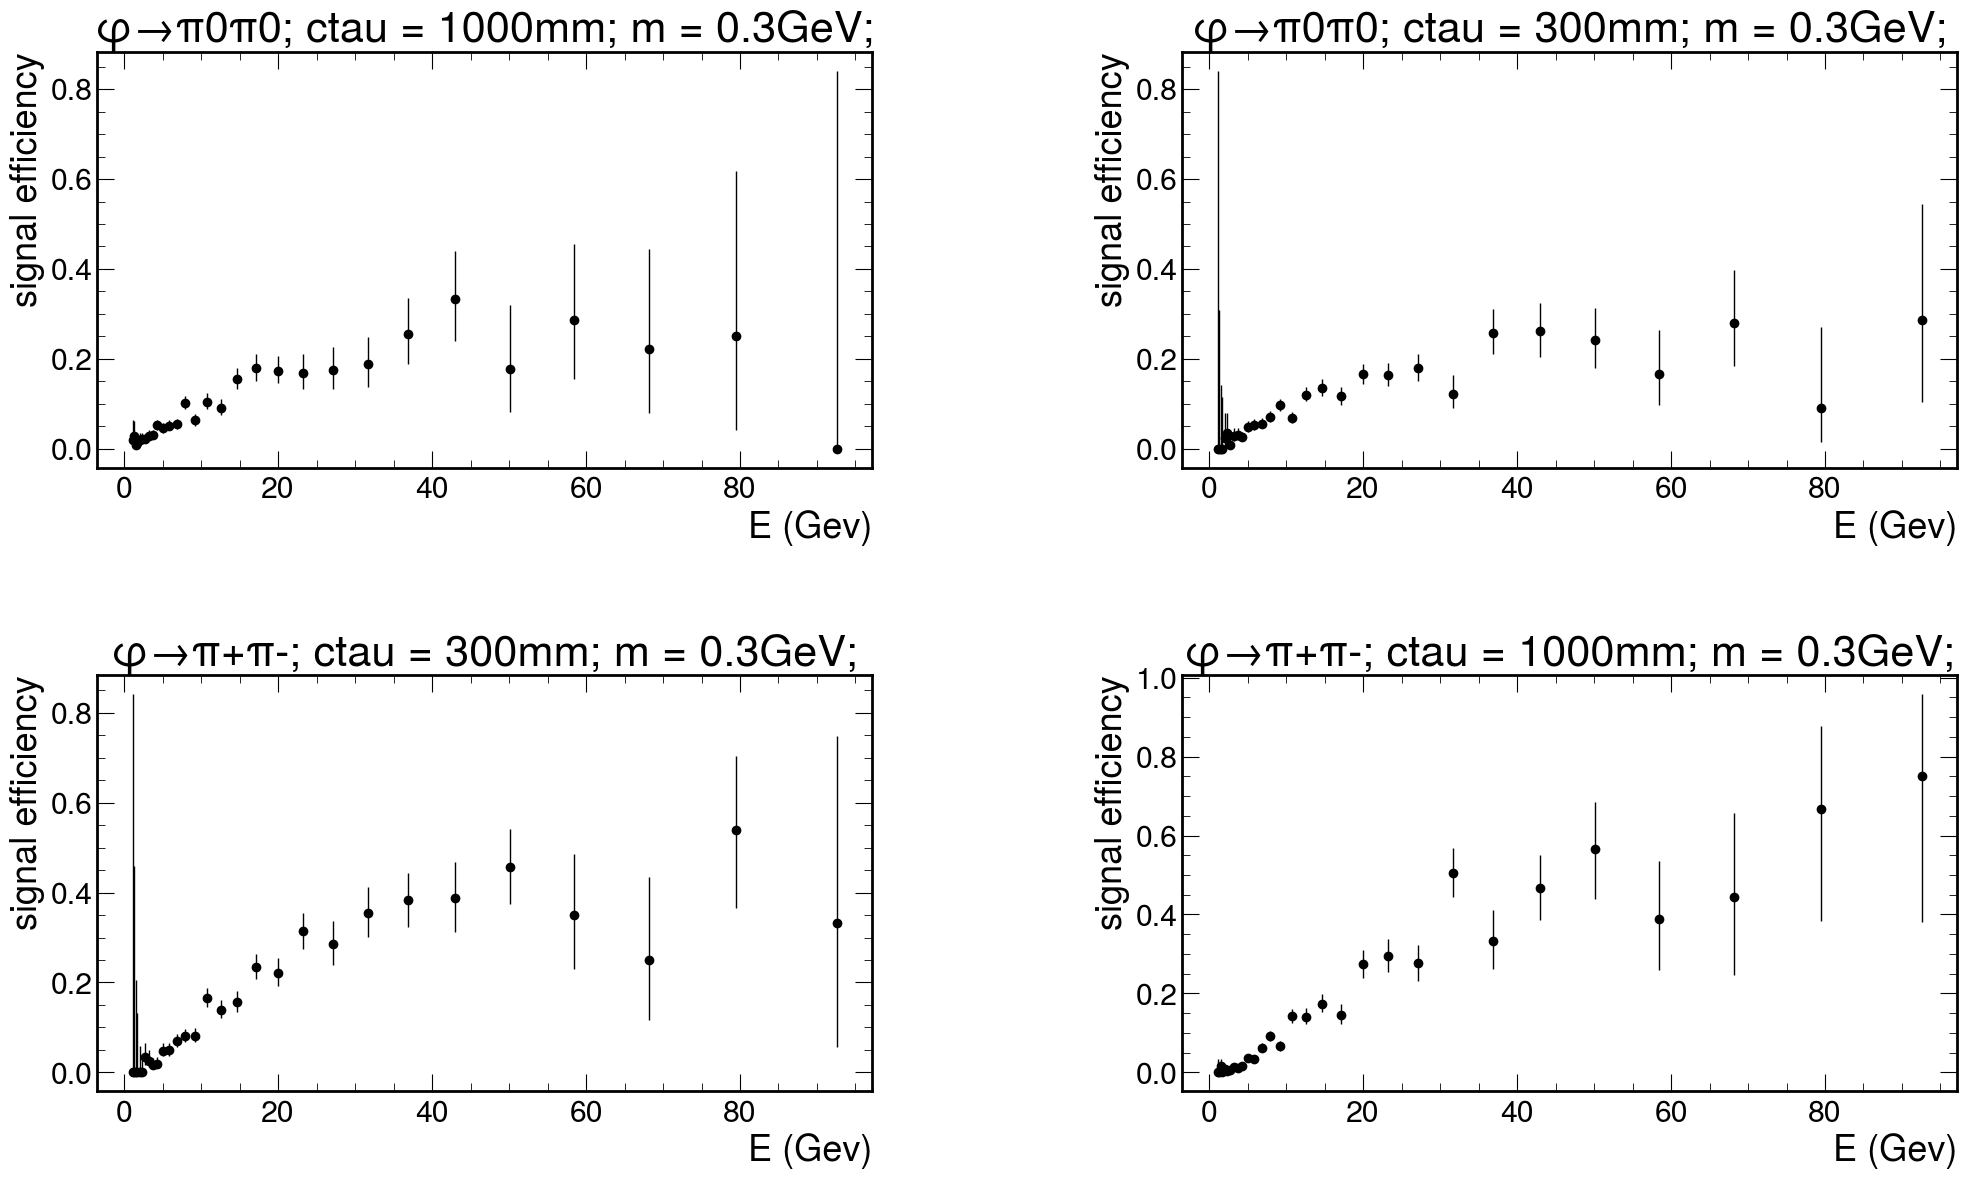

In [9]:
a = 1.5
fig, axes = plt.subplots(2,2, figsize = (a*16,a*9))

for ax, key in zip(axes.flatten(), 'PhiToPiPlusPiMinus_mPhi0p3_ctau1000','PhiToPiPlusPiMinus_mPhi0p3_ctau300','PhiToPi0Pi0_mPhi0p3_ctau300','PhiToPi0Pi0_mPhi0p3_ctau1000',):
    ratio(out[key]['gLLP_e_matched with no_cut'], out[key]['gLLP_e with no_cut'], ax)
    ax.set_xlabel("E (Gev)")
    ax.set_ylabel("signal efficiency")
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '
        
    if '0p3' in key:
        s+='m = 0.3GeV;'
    if '1p0' in key:
        s+='m = 1.0GeV;'
        
    ax.set_title(s)
        
fig.subplots_adjust(hspace=.5, wspace=.4)
        
plt.show()

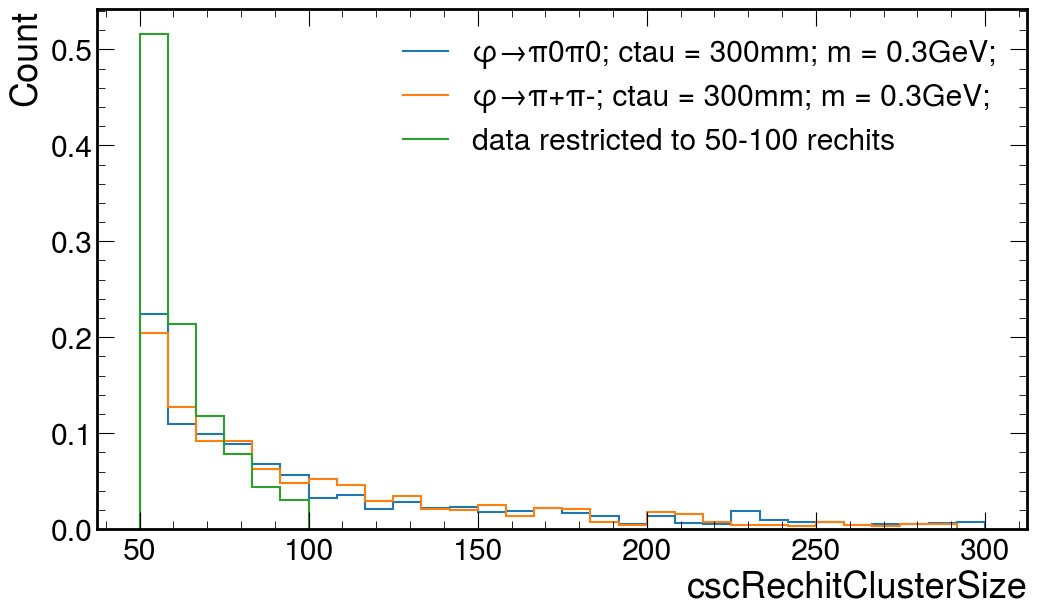

In [22]:
a = .75
fig, ax = plt.subplots(figsize = (a*16,a*9))

for key in [datasets[i] for i in [1,2,4]]:
    
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '

    if '0p3' in key:
        s+='m = 0.3GeV;'
    if '1p0' in key:
        s+='m = 1.0GeV;'

    if 'background' in key:
        s+='data restricted to 50-100 rechits'
        temp = out[key][f'cscRechitClusterSize with in_csc'][:100j]/out[key][f'cscRechitClusterSize with in_csc'].sum()
    else:
        temp = out[key][f'cscRechitClusterSize with in_csc']/out[key][f'cscRechitClusterSize with in_csc'].sum()
    
    hep.histplot(temp, label = s, ax=ax)

plt.ylabel('Count')        
plt.legend()
plt.show()

In [24]:
datasets

['PhiToPi0Pi0_mPhi0p3_ctau1000',
 'PhiToPi0Pi0_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau1000',
 'backgroundNew']

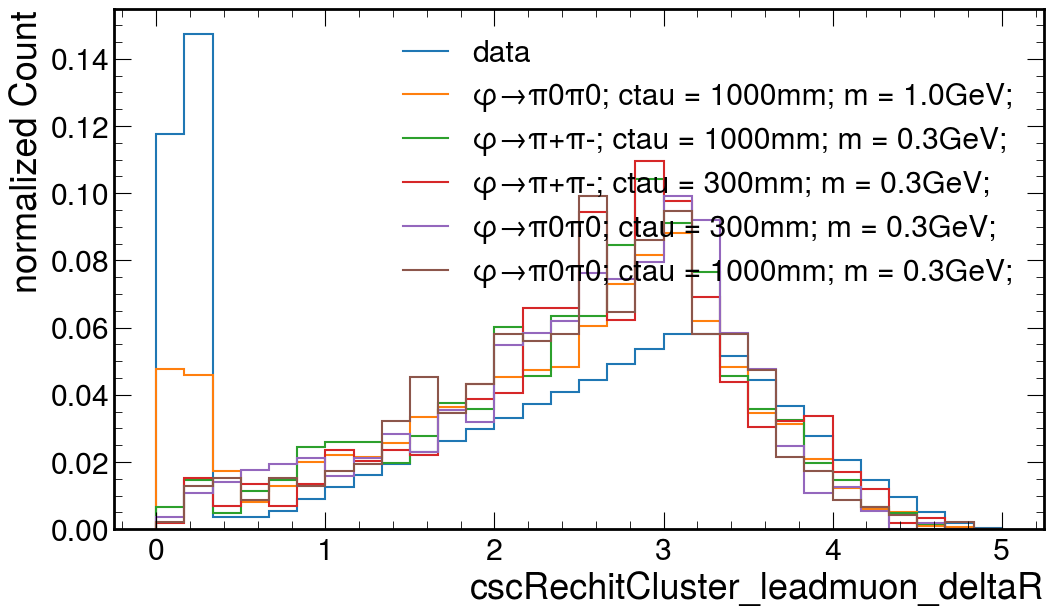

In [26]:
a = .75
fig, ax = plt.subplots(figsize = (a*16,a*9))
for key in datasets:
    s = ''
    if 'PiPlusPiMinus' in key:
        s+='φ→π+π-; '
    if 'Pi0Pi0' in key:
        s+='φ→π0π0; '

    if 'ctau1000' in key:
        s+='ctau = 1000mm; '
    if 'ctau300' in key:
        s+='ctau = 300mm; '

    if '0p3' in key:
        s+='m = 0.3GeV;'
    if '1p0' in key:
        s+='m = 1.0GeV;'

    if 'background' in key:
        s+='data'

    temp = out[key][f'cscRechitCluster_leadmuon_deltaR with dR_gllp_cls < .4']/out[key][f'cscRechitCluster_leadmuon_deltaR with dR_gllp_cls < .4'].sum()

    hep.histplot(temp, label = s, ax=ax)

plt.ylabel('normalized Count')        
plt.legend()
plt.show()

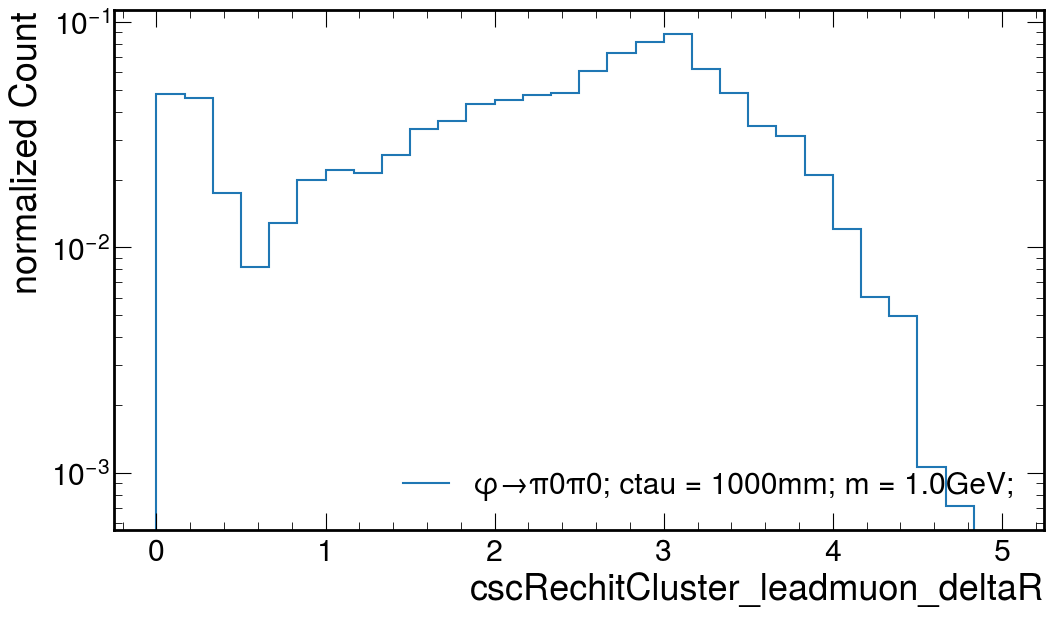

In [36]:
a = .75
fig, ax = plt.subplots(figsize = (a*16,a*9))
key = 'PhiToPi0Pi0_mPhi0p3_ctau1000'
s = ''
if 'PiPlusPiMinus' in key:
    s+='φ→π+π-; '
if 'Pi0Pi0' in key:
    s+='φ→π0π0; '

if 'ctau1000' in key:
    s+='ctau = 1000mm; '
if 'ctau300' in key:
    s+='ctau = 300mm; '

if '0p3' in key:
    s+='m = 0.3GeV;'
if '1p0' in key:
    s+='m = 1.0GeV;'

if 'background' in key:
    s+='data'

temp = out[key][f'cscRechitCluster_leadmuon_deltaR with dR_gllp_cls < .4']/out[key][f'cscRechitCluster_leadmuon_deltaR with dR_gllp_cls < .4'].sum()

hep.histplot(temp, label = s, ax=ax)


plt.ylabel('normalized Count')        
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

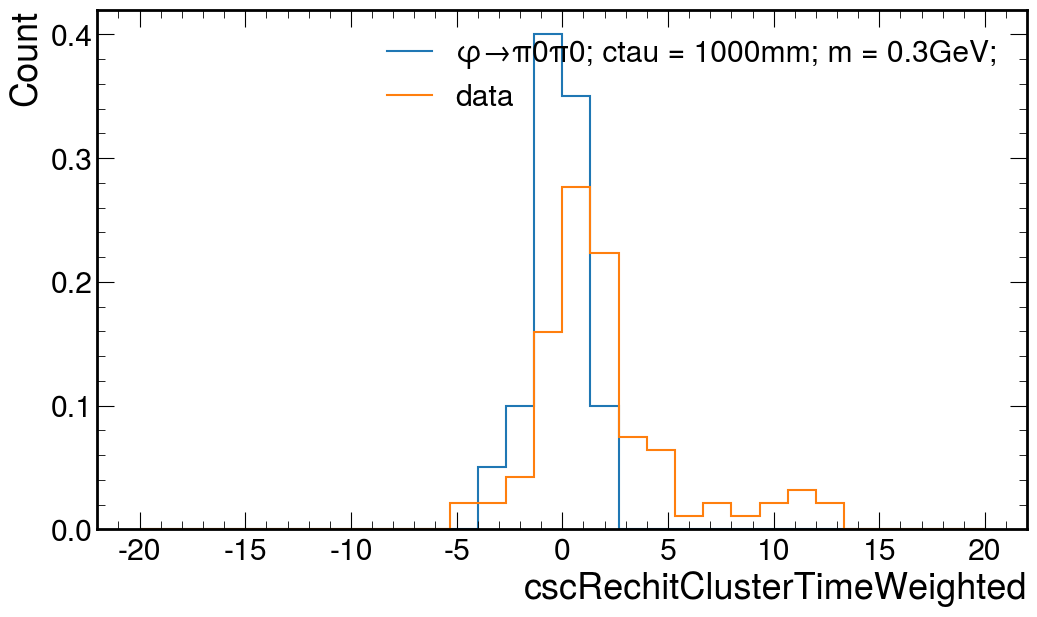

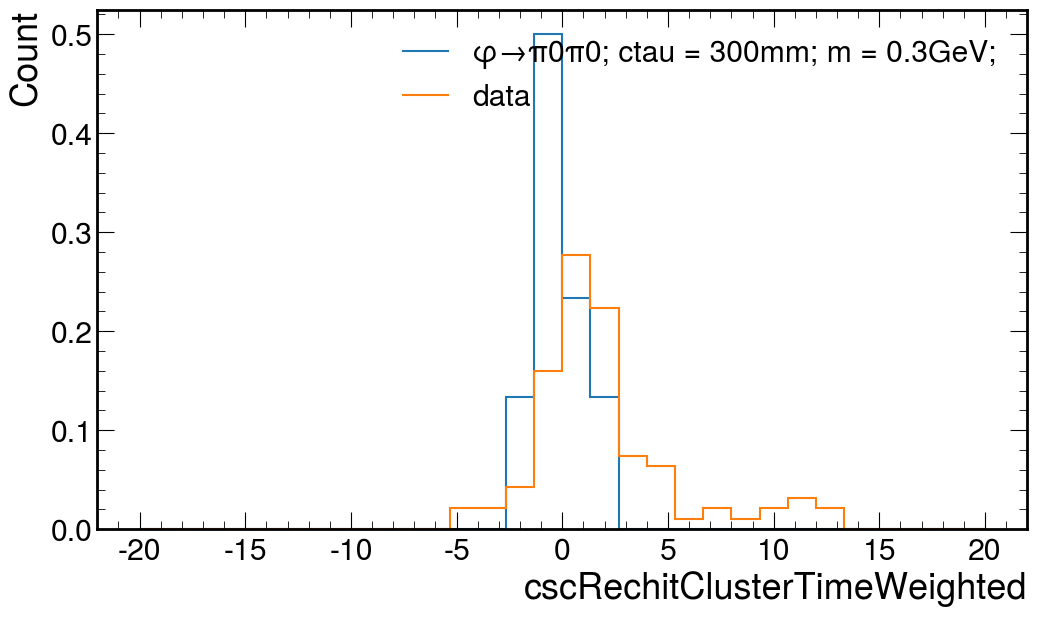

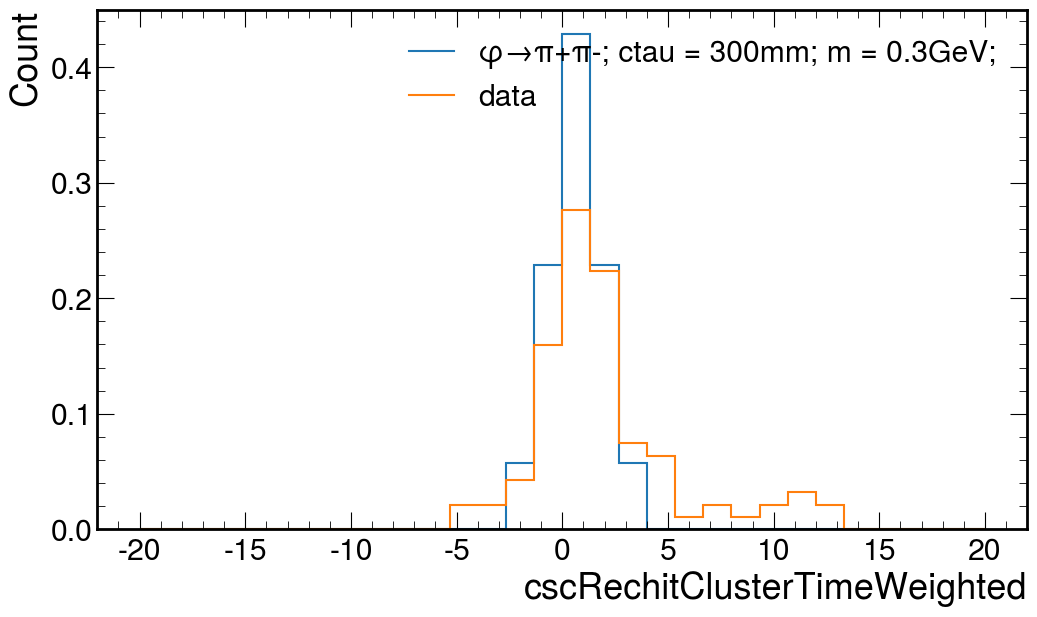

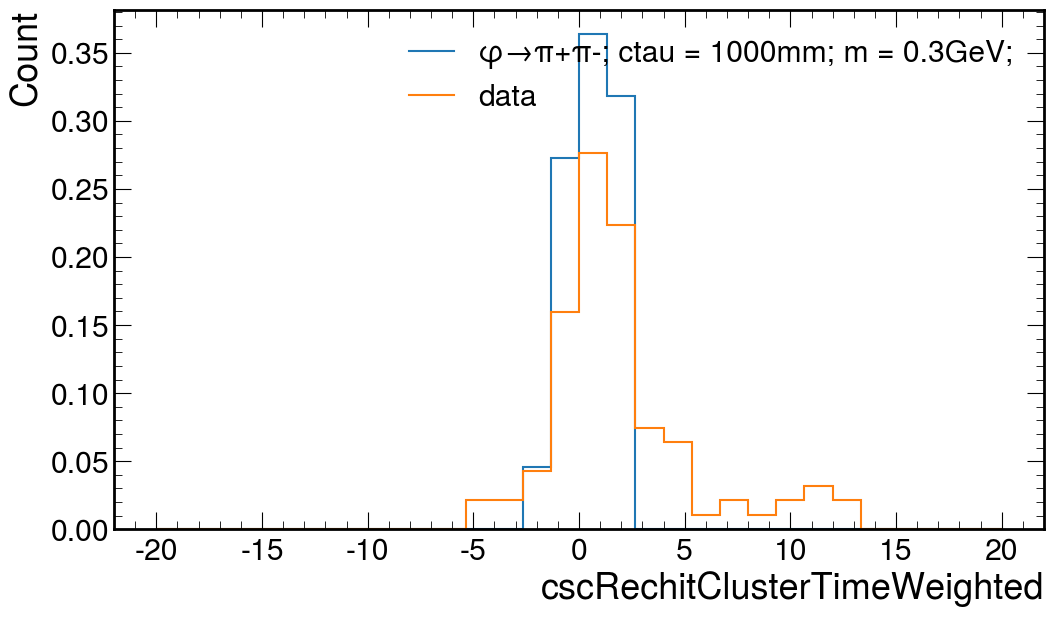

In [14]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitClusterTimeWeighted with cut_based_ID']/out[key][f'cscRechitClusterTimeWeighted with cut_based_ID'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('Count')        
    plt.legend()
    plt.show()

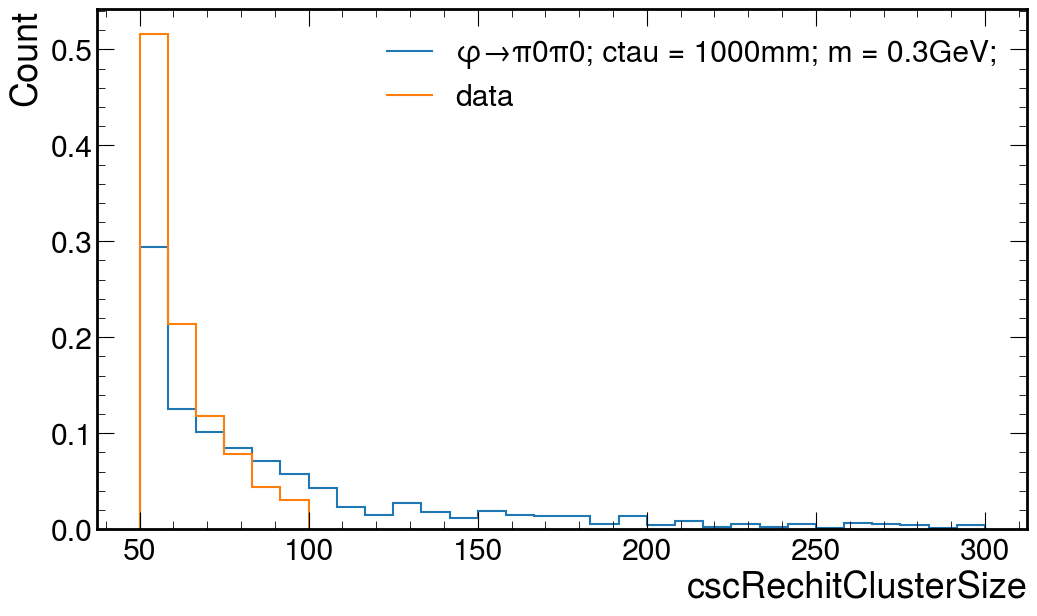

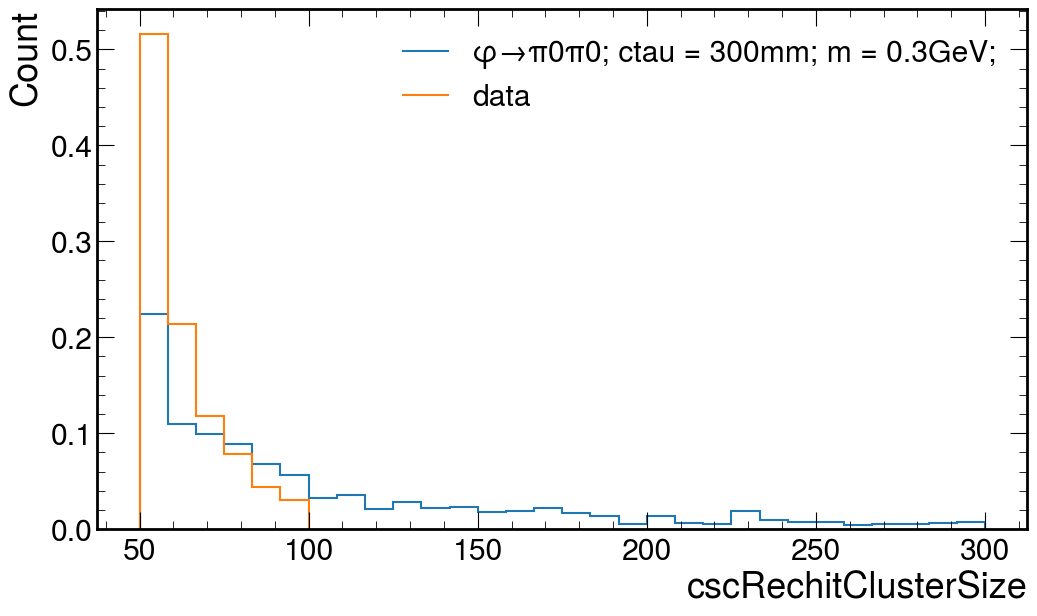

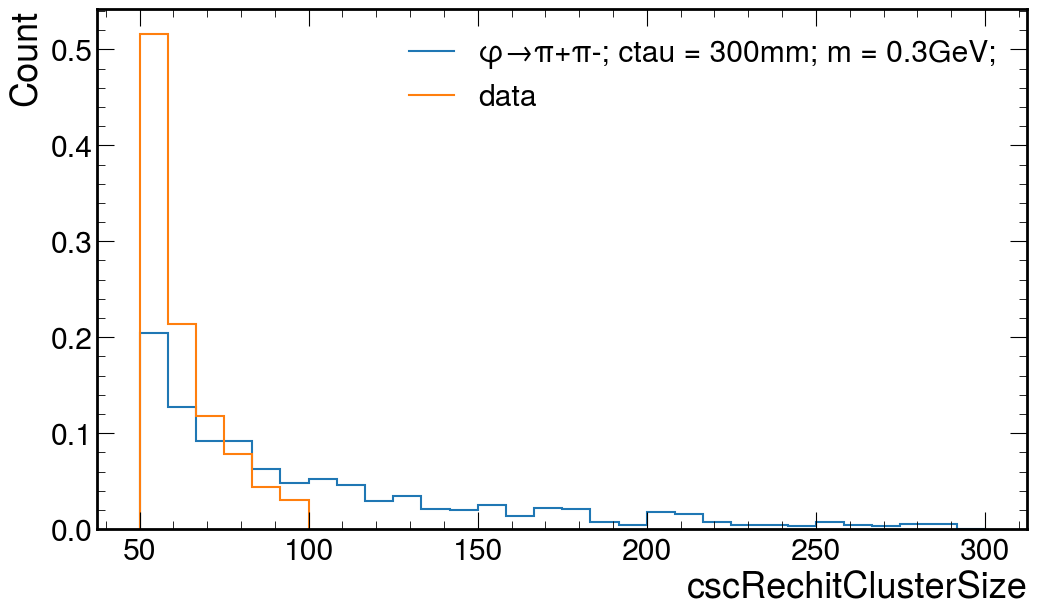

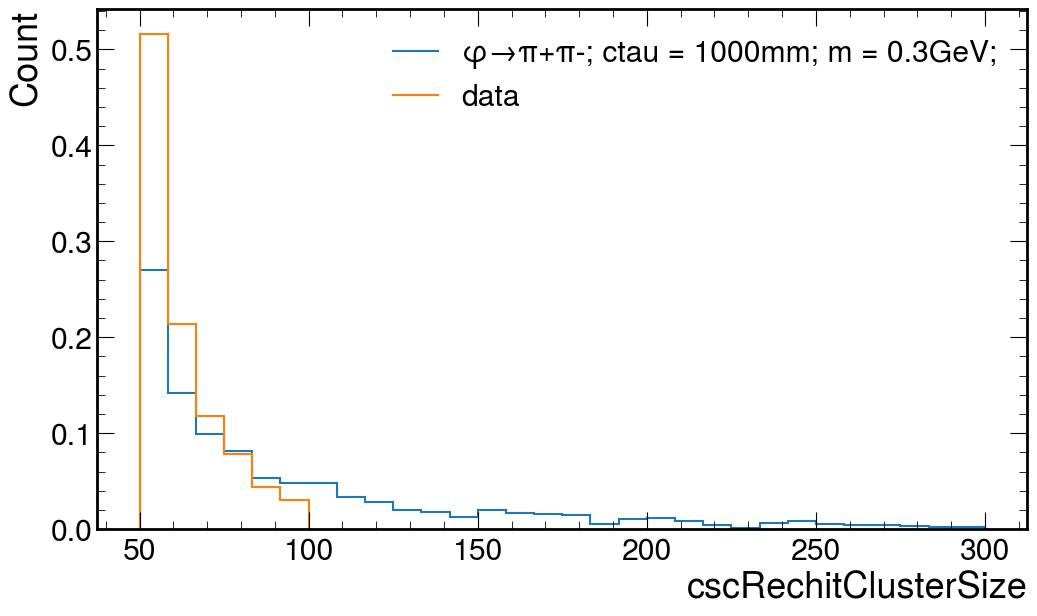

In [20]:
a = .75
for j in range(4):
    fig, ax = plt.subplots(figsize = (a*16,a*9))

    for key in [datasets[i] for i in [j,-1]]:

        s = ''
        if 'PiPlusPiMinus' in key:
            s+='φ→π+π-; '
        if 'Pi0Pi0' in key:
            s+='φ→π0π0; '

        if 'ctau1000' in key:
            s+='ctau = 1000mm; '
        if 'ctau300' in key:
            s+='ctau = 300mm; '

        if '0p3' in key:
            s+='m = 0.3GeV;'
        if '1p0' in key:
            s+='m = 1.0GeV;'

        if 'background' in key:
            s+='data'

        temp = out[key][f'cscRechitClusterSize with in_csc']/out[key][f'cscRechitClusterSize with in_csc'].sum()

        hep.histplot(temp, label = s, ax=ax)

    plt.ylabel('Count')        
    plt.legend()
    plt.show()